In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import keras

import gzip
%matplotlib inline

from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [4]:
# Définir les chemins vers les dossiers de données
data_dir = '/kaggle/input/data-sets/Data_project'
conforme_dir = os.path.join(data_dir,"Data_conforme")
non_conforme_dir = os.path.join(data_dir, 'BBD_non-conforme')

In [5]:
# Fonction pour obtenir les dimensions des images
def get_image_dimensions(directory):
    widths = []
    heights = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".JPG"):
            image_path = os.path.join(directory, filename)
            img = Image.open(image_path)
            widths.append(img.width)
            heights.append(img.height)
    return widths, heights

# Calculer les dimensions moyennes
widths, heights = get_image_dimensions(conforme_dir)
mean_width = int(np.mean(widths))
mean_height = int(np.mean(heights))

print(f"Dimensions moyennes : {mean_width}x{mean_height}")

Dimensions moyennes : 1206x2542


In [6]:
# Définir les paramètres
img_height, img_width = 256, 256
max_pixel_value = 255.0

# Fonction pour redimensionner les images
def resize_image(image, target_height, target_width):
    return image.resize((target_width, target_height), Image.ANTIALIAS)

# Fonction pour charger et normaliser les images
def load_and_normalize_images(directory, img_height, img_width):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".JPG"):
            image_path = os.path.join(directory, filename)
            try:
                img = Image.open(image_path)
                img = resize_image(img, img_height, img_width)
                img = np.array(img) / max_pixel_value  # Normalisation
                images.append(img)
            except Exception as e:
                print(f"Erreur en traitant {image_path}: {e}")
    return np.array(images)

# Charger et normaliser les images conformes
conforme_images = load_and_normalize_images(conforme_dir, img_height, img_width)

# Vérifier la forme des données
print("Taille de l'ensemble des images conformes :", conforme_images.shape)

/tmp/ipykernel_33/1821104324.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize((target_width, target_height), Image.ANTIALIAS)


Taille de l'ensemble des images conformes : (276, 256, 256, 3)


In [7]:
# Diviser les données en ensembles d'entraînement et de validation
train_images, val_images = train_test_split(conforme_images, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", len(train_images))
print("Taille de l'ensemble de validation :", len(val_images))

Taille de l'ensemble d'entraînement : 220
Taille de l'ensemble de validation : 56


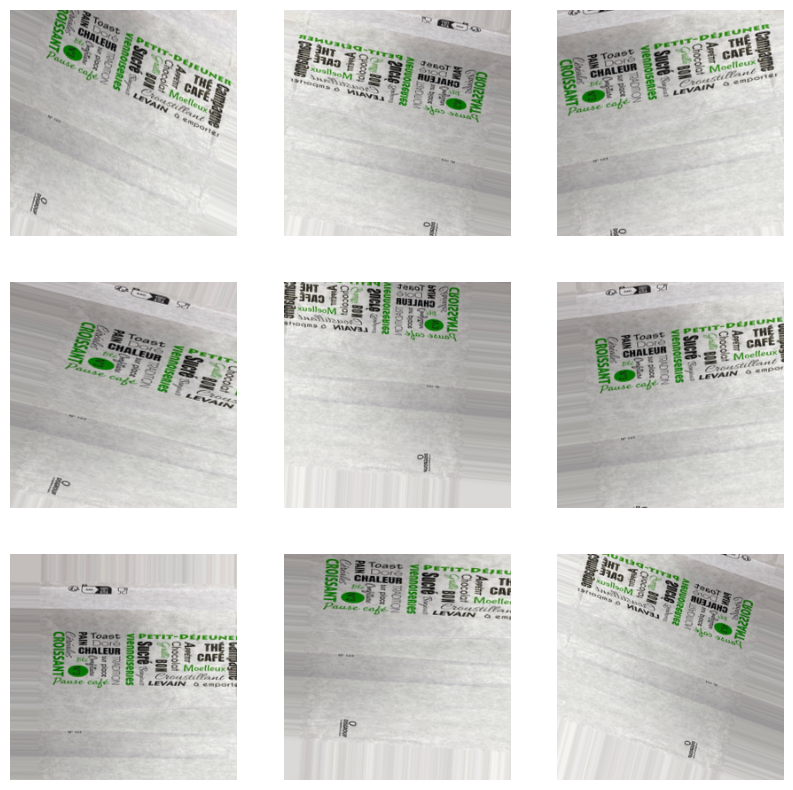

Taille des images augmentées : (2760, 256, 256, 3)
Taille des étiquettes augmentées : (2760,)


In [8]:
# Convertir les images en un tableau numpy
conforme_images = np.array(conforme_images)

# Créer un générateur d'images pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Choisir un exemple d'image pour afficher les augmentations
sample_image = conforme_images[0]
sample_image = np.expand_dims(sample_image, axis=0)  # Ajouter une dimension pour correspondre à l'entrée attendue par le générateur

# Générer des exemples augmentés et les afficher
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = next(datagen.flow(sample_image, batch_size=1))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')
plt.show()

# Appliquer l'augmentation de données à l'ensemble des images conformes
augmented_images = []
augmented_labels = []  # Si vous avez des étiquettes, vous pouvez les gérer ici

for img in conforme_images:
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour correspondre à l'entrée attendue par le générateur
    for _ in range(10):  # Générer 10 augmentations par image originale
        augmented_image = next(datagen.flow(img, batch_size=1))
        augmented_images.append(augmented_image[0])
        augmented_labels.append(1)  # Vous pouvez ajouter les étiquettes ici, si nécessaire

# Convertir la liste des images augmentées en un tableau numpy
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print("Taille des images augmentées :", augmented_images.shape)
print("Taille des étiquettes augmentées :", augmented_labels.shape)


In [9]:
def encoder(input_img):
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img) # 256 x 256 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.25)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 128 x 128 x 32

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool1) # 128 x 128 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.25)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 64 x 64 x 64

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool2) # 64 x 64 x 128
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.25)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 32 x 32 x 128

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(pool3) # 32 x 32 x 256
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.25)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(encoded):
    # Decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(encoded) # 32 x 32 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.25)(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv5)
    conv5 = BatchNormalization()(conv5)
    up1 = UpSampling2D((2, 2))(conv5) # 64 x 64 x 128

    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up1) # 64 x 64 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.25)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv6)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2, 2))(conv6) # 128 x 128 x 64

    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(up2) # 128 x 128 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.25)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv7)
    conv7 = BatchNormalization()(conv7)
    up3 = UpSampling2D((2, 2))(conv7) # 256 x 256 x 32

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) # 256 x 256 x 3
    return decoded

input_img = Input(shape=(256, 256, 3))
encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,759,811 (6.71 MB)

 Trainable params: 1,756,995 (6.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

None


In [10]:
# Configurations
batch_size = 32
epochs = 50

# Entraîner l'autoencodeur
history = autoencoder.fit(
    datagen.flow(train_images, train_images, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(val_images, val_images),
    verbose=1
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 125s 18s/step - accuracy: 0.3165 - loss: 1.3534 - val_accuracy: 0.0144 - val_loss: 1.0555
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 1:12 14s/step - accuracy: 0.3147 - loss: 1.0688

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3147 - loss: 1.0688 - val_accuracy: 0.0105 - val_loss: 1.0028
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 110s 18s/step - accuracy: 0.3120 - loss: 0.9395 - val_accuracy: 0.0070 - val_loss: 0.7248
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3198 - loss: 0.7252 - val_accuracy: 0.0070 - val_loss: 0.6844
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 117s 18s/step - accuracy: 0.3252 - loss: 0.6328 - val_accuracy: 0.0106 - val_loss: 0.4819
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3365 - loss: 0.4836 - val_accuracy: 0.0105 - val_loss: 0.4546
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 112s 18s/step - accuracy: 0.3283 - loss: 0.4325 - val_accuracy: 0.0078 - val_loss: 0.3481
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3381 - loss: 0.3588 - val_accuracy: 0.0155 - val_loss: 0.3365
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 110s 18s/step - accuracy: 0.3592 - loss: 0.3309 - val_accuracy: 0.7600 - val_loss: 0.2819
Epoch 10/50

In [11]:
# Évaluer le modèle
loss, accuracy = autoencoder.evaluate(val_images, val_images)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2347 - loss: 0.0375
Validation Loss: 0.0376640222966671
Validation Accuracy: 0.23236219584941864


In [12]:
train_loss, train_accuracy = autoencoder.evaluate(train_images, train_images)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = autoencoder.evaluate(val_images, val_images)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.2302 - loss: 0.0373
Train loss: 0.037735067307949066
Train accuracy: 0.22543543577194214
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2347 - loss: 0.0375
Test loss: 0.0376640222966671
Test accuracy: 0.23236219584941864


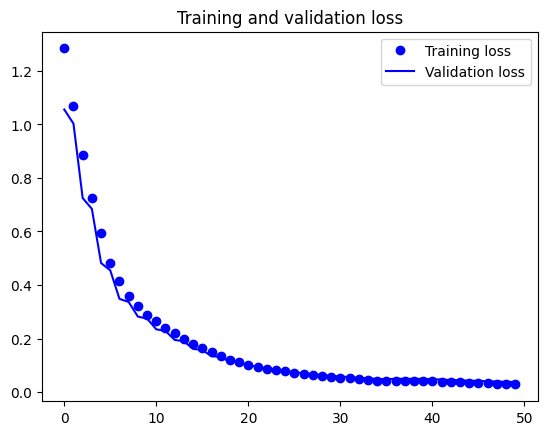

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


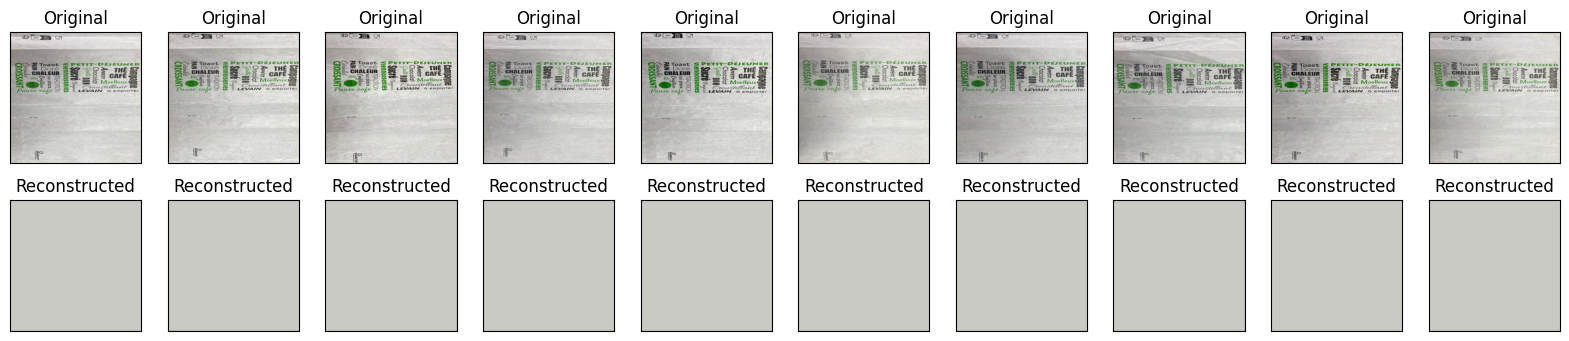

In [14]:
# Visualiser quelques reconstructions
n = 10  # Nombre d'images à visualiser
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_images[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_img = autoencoder.predict(np.expand_dims(val_images[i], axis=0))
    plt.imshow(reconstructed_img.squeeze())
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
# Sauvegarder uniquement les poids
autoencoder.save_weights('autoencoder.weights.h5')

# Sauvegarder le modèle complet
autoencoder.save('autoencoder.h5')

In [16]:
# Génération des étiquettes pour les données conformes (0 = conforme)
train_labels = np.zeros(len(train_images))  # Toutes les images d'entraînement sont conformes
val_labels = np.zeros(len(val_images))      # Toutes les images de validation sont conformes


In [17]:
from keras.utils import to_categorical

# Encoder les étiquettes en one-hot
train_Y_one_hot = to_categorical(train_labels, num_classes=2)
val_Y_one_hot = to_categorical(val_labels, num_classes=2)

In [18]:
# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0.0
After conversion to one-hot: [1. 0.]


In [19]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [20]:
num_classes = 2

In [21]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [22]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [24]:
full_model.get_weights()[0][1]

array([[[ 4.71966639e-02, -1.85661465e-02,  4.44326252e-02,
          8.81316978e-03, -1.10063381e-01, -1.49870086e-02,
         -6.15978576e-02, -5.69940954e-02,  1.46558858e-03,
         -7.55620375e-02, -3.65161076e-02,  3.57504264e-02,
         -1.10002505e-02, -6.44710660e-02,  5.39352885e-03,
         -3.00132725e-02,  9.23666265e-03, -1.69643386e-06,
          1.35904923e-02, -1.53315663e-02, -9.15842503e-03,
          2.41560768e-02,  2.63876617e-02, -5.06669693e-02,
         -5.65537205e-03, -4.21399989e-07, -9.87286195e-02,
          3.67334820e-02, -5.38132153e-02, -1.06407538e-01,
         -1.54762361e-02, -4.78700064e-02],
        [-2.95911562e-02, -3.97770070e-02,  3.28757949e-02,
         -8.43966156e-02,  2.98337154e-02,  1.12516820e-01,
         -2.39277333e-02,  6.89233020e-02,  2.34011505e-02,
          1.05253672e-02,  3.68875898e-02, -4.47220169e-03,
         -6.29993039e-04, -9.40149464e-03,  6.24116659e-02,
          8.15075450e-03,  3.27710062e-02, -1.41286118e-

In [25]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [26]:

# Compiler le modèle complet
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle complet
full_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 34,730,914 (132.49 MB)

 Trainable params: 34,441,090 (131.38 MB)

 Non-trainable params: 289,824 (1.11 MB)

In [27]:
# Entraîner le modèle complet pour la classification
classify_train = full_model.fit(train_images, train_Y_one_hot, 
                                batch_size=64,
                                epochs=100,
                                verbose=1,
                                validation_data=(val_images, val_Y_one_hot))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.6604 - loss: 0.9150 - val_accuracy: 0.0000e+00 - val_loss: 335.8111
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 1.0000 - loss: 0.3969 - val_accuracy: 0.0000e+00 - val_loss: 696.0174
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 1.0000 - loss: 0.3760 - val_accuracy: 0.0000e+00 - val_loss: 985.7353
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 1.0000 - loss: 0.3589 - val_accuracy: 0.0000e+00 - val_loss: 1194.2225
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 1.0000 - loss: 0.3452 - val_accuracy: 0.0000e+00 - val_loss: 1326.6761
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 1.0000 - loss: 0.3345 - val_accuracy: 0.0000e+00 - val_loss: 1400.1643
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 1.0000 - loss: 0.3261 - val_accuracy: 0.0000e+00 - val_loss: 1430.8782
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 1.0000 - loss: 0.3

In [51]:
train_loss, train_accuracy = full_model.evaluate(train_images, train_images)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = full_model.evaluate(val_images, val_images)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

ValueError: Dimensions must be equal, but are 3 and 2 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](IteratorGetNext:1, functional_3_1/dense_1_2/Softmax)' with input shapes: [?,256,256,3], [?,2].

In [ ]:
train_loss, train_accuracy = autoencoder.evaluate(train_images, train_images)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = autoencoder.evaluate(val_images, val_images)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

In [40]:
# Sauvegarder uniquement les poids
full_model.save_weights('autoencoder_vf.weights.h5')

# Sauvegarder le modèle complet
full_model.save('autoencoder_vf.h5')

In [32]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [39]:

# Utilisation de mean_squared_error pour l'auto-encodage
full_model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

# Assurez-vous que les cibles sont les mêmes que les entrées pour l'auto-encodage
classify_train = full_model.fit(train_images, train_images, batch_size=64, epochs=100, verbose=1, validation_data=(val_images, val_images))


Epoch 1/100


ValueError: Dimensions must be equal, but are 3 and 2 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, functional_3_1/dense_1_2/Softmax)' with input shapes: [?,256,256,3], [?,2].

In [38]:
classify_train = full_model.fit(train_images, train_images, batch_size=64,epochs=100,verbose=1,validation_data=(val_images, val_images))

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 256, 256, 3), output.shape=(None, 2)

In [ ]:
full_model.save_weights('classification_complete.h5')


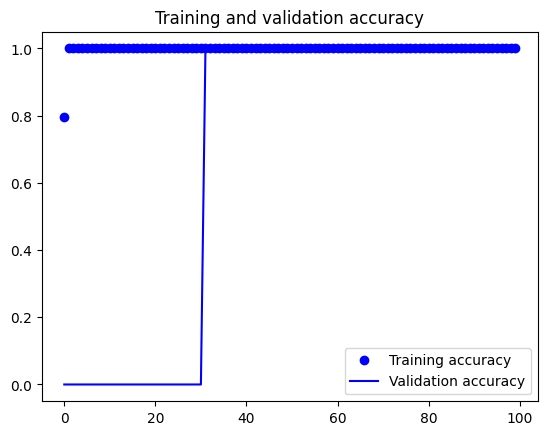

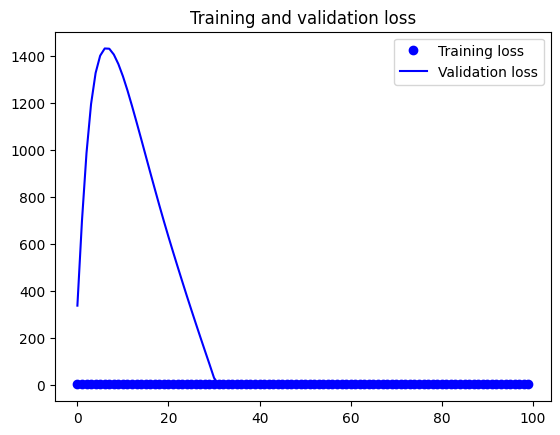

In [44]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [47]:
test_eval = full_model.evaluate(val_images, test_Y_one_hot, verbose=0)


NameError: name 'test_Y_one_hot' is not defined

In [48]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


NameError: name 'test_eval' is not defined

In [49]:
predicted_classes = full_model.predict(test_data)


NameError: name 'test_data' is not defined